In [1]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Load the dataset
df = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')


# Overview
print("Shape of the dataset:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape of the dataset: (614, 13)
Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [2]:
print(df.head())
print(df.shape)

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [3]:
# --- Inject Dummy Columns for Demo Purposes ---

# Constant Feature: All same value
df['constant_feature'] = 1

# Quasi-Constant Feature: 99.2% same value
df['quasi_constant_feature'] = [1]*608 + [0]*6

# Duplicate Feature: Exact copy of 'ApplicantIncome'
df['duplicate_applicant_income'] = df['ApplicantIncome']


In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,constant_feature,quasi_constant_feature,duplicate_applicant_income
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,1,1,5849
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,1,1,4583
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,1,1,3000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,1,1,2583
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,1,1,6000


In [5]:
# Constant features: Only one unique value
constant_features = [col for col in df.columns if df[col].nunique() == 1]
print("🔹 Constant Features (nunique == 1):", constant_features)


🔹 Constant Features (nunique == 1): ['constant_feature']


In [6]:
from sklearn.model_selection import train_test_split

# Drop ID column (not useful for ML)
df = df.drop('Loan_ID', axis=1)

# Drop rows with missing values for simplicity
df = df.dropna()

# Convert categorical to numeric using Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoders = {}

for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Separate features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Constant Features
constant_features = [col for col in X_train.columns if X_train[col].nunique() == 1]
print("🔹 Constant Features:", constant_features)


🔹 Constant Features: ['constant_feature']


In [8]:
# Quasi-Constant Features
quasi_constant_features = []

for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True).values[0]
    if top_freq > 0.98:
        quasi_constant_features.append(col)

print("🔸 Quasi-Constant Features (>=98% same):", quasi_constant_features)


🔸 Quasi-Constant Features (>=98% same): ['constant_feature', 'quasi_constant_feature']


In [9]:
# Duplicate Columns
duplicate_features = []
cols = X_train.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X_train[cols[i]].equals(X_train[cols[j]]):
            duplicate_features.append((cols[i], cols[j]))

print("🔁 Duplicate Features:", duplicate_features)


🔁 Duplicate Features: [('ApplicantIncome', 'duplicate_applicant_income')]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128310 (\N{LARGE ORANGE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


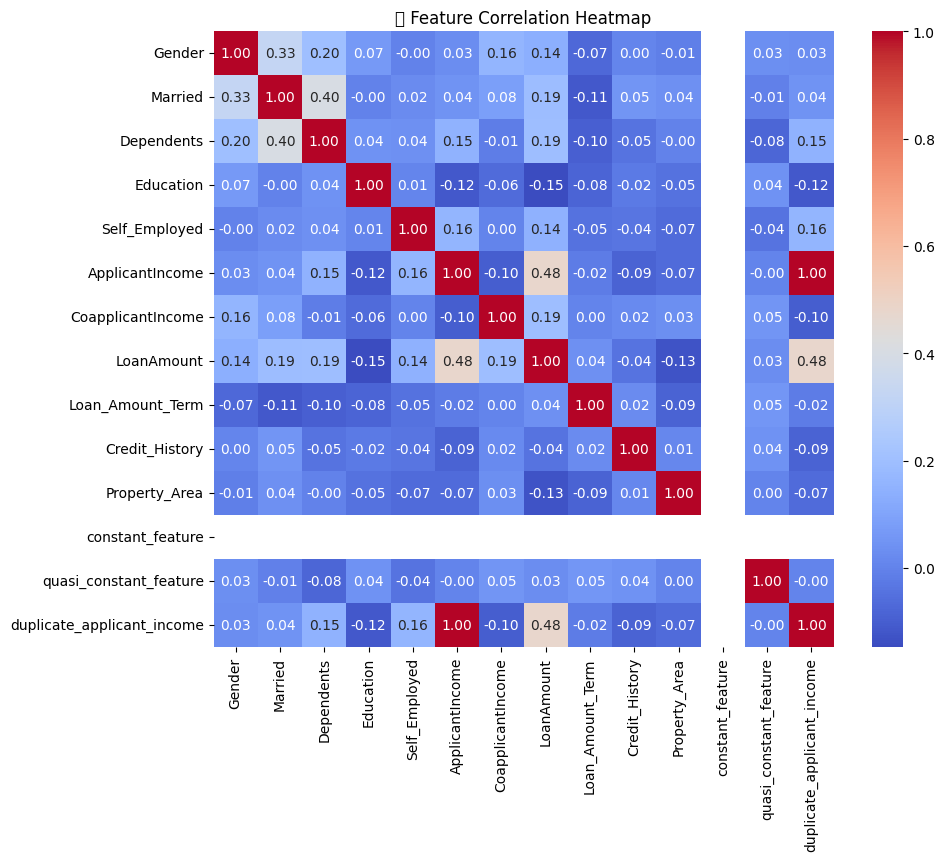

📈 Highly Correlated Feature Pairs (|corr| > 0.8):
duplicate_applicant_income ↔ ApplicantIncome = 1.00


In [10]:
corr_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔶 Feature Correlation Heatmap")
plt.show()

# Pairs with high correlation
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("📈 Highly Correlated Feature Pairs (|corr| > 0.8):")
for col1, col2, score in high_corr:
    print(f"{col1} ↔ {col2} = {score:.2f}")

💡 Mutual Information Scores:
Credit_History                0.138709
Education                     0.035866
Married                       0.019771
Dependents                    0.017242
Property_Area                 0.012107
quasi_constant_feature        0.004420
Gender                        0.000000
Self_Employed                 0.000000
ApplicantIncome               0.000000
CoapplicantIncome             0.000000
LoanAmount                    0.000000
Loan_Amount_Term              0.000000
constant_feature              0.000000
duplicate_applicant_income    0.000000
dtype: float64


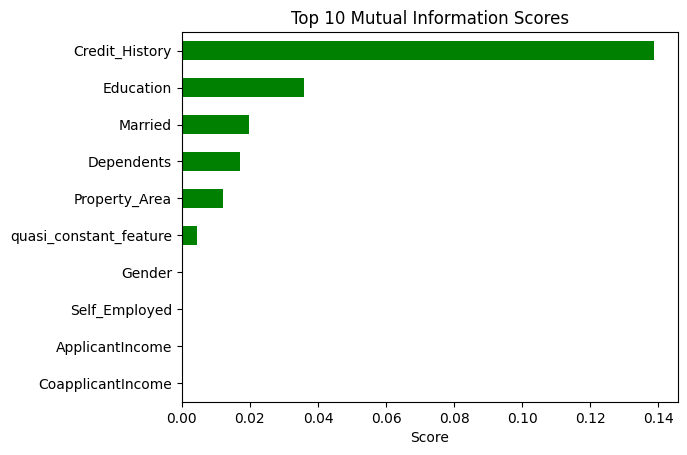

In [11]:
mi_scores = mutual_info_classif(X_train, y_train)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

print("💡 Mutual Information Scores:")
print(mi_series)

# Plot Top 10
mi_series.head(10).plot(kind='barh', color='green')
plt.title("Top 10 Mutual Information Scores")
plt.xlabel("Score")
plt.gca().invert_yaxis()
plt.show()